In [ ]:
import pandas as pd
df = pd.read_csv('american_bankruptcy.csv')


In [ ]:
df.shape

(78682, 21)

In [ ]:
df.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [ ]:
df.isnull().sum()

,0
company_name,0
status_label,0
year,0
X1,0
X2,0
X3,0
X4,0
X5,0
X6,0
X7,0


In [ ]:
company_counts = df['company_name'].value_counts()
print("company_name counts: ",company_counts)

company_name counts:  company_name
C_17      20
C_14      20
C_6652    20
C_6651    20
C_6640    20
          ..
C_4655     1
C_4656     1
C_68       1
C_8905     1
C_8908     1
Name: count, Length: 8971, dtype: int64


In [ ]:
unique_companies = df['company_name'].unique()
num_companies = len(unique_companies)
print(f"There are {num_companies} unique companies in the dataset.")

There are 8971 unique companies in the dataset.


company_name counts:  company_name
C_17      20
C_14      20
C_6652    20
C_6651    20
C_6640    20
          ..
C_4655     1
C_4656     1
C_68       1
C_8905     1
C_8908     1
Name: count, Length: 8971, dtype: int64


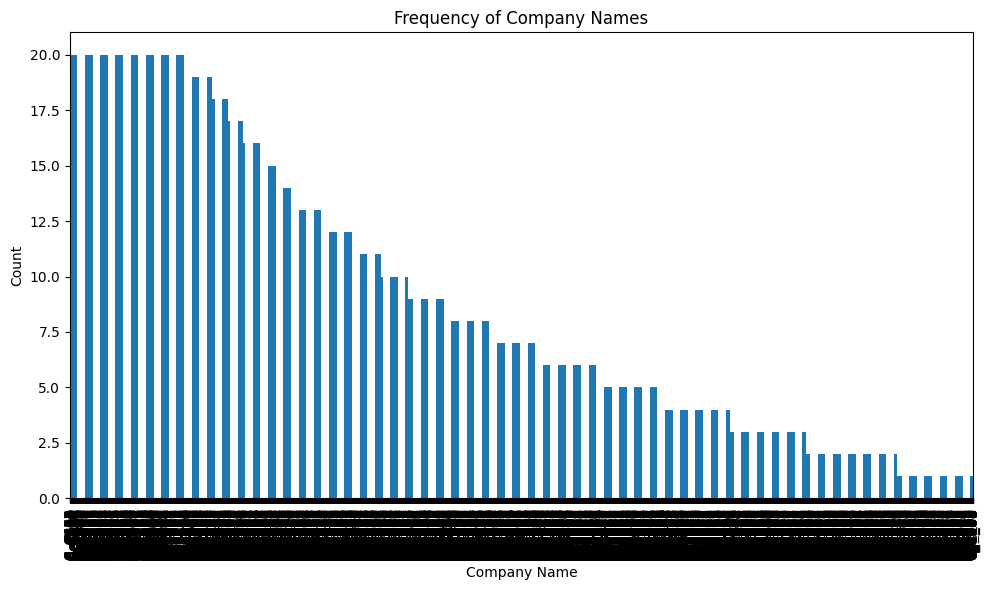

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ... (your existing code to load and process the dataframe) ...

company_counts = df['company_name'].value_counts()
print("company_name counts: ", company_counts)

# Plotting
company_counts.plot(kind='bar', figsize=(10, 6))  # Adjust figsize as needed
plt.title('Frequency of Company Names')
plt.xlabel('Company Name')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
df['status_label'].value_counts()

,count
status_label,
alive,73462
failed,5220


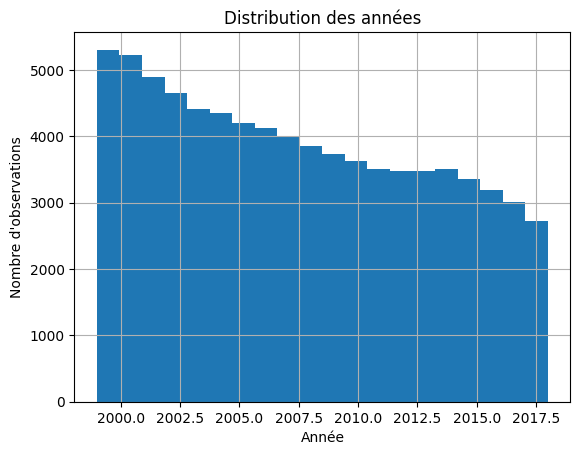

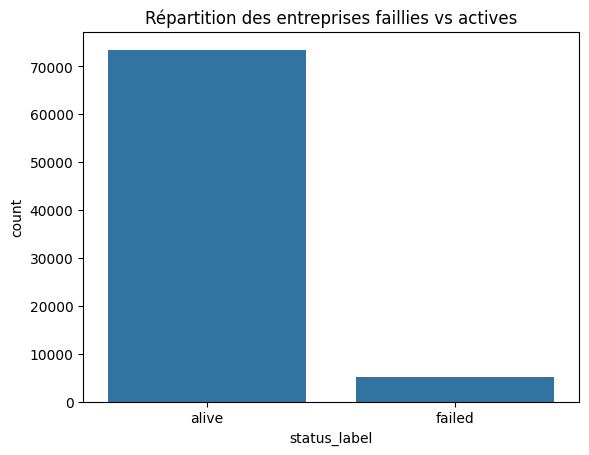

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution des années par entreprise
df['year'].hist(bins=20)
plt.title("Distribution des années")
plt.xlabel("Année")
plt.ylabel("Nombre d'observations")
plt.show()

# Répartition des statuts (failed vs alive)
sns.countplot(data=df, x='status_label')
plt.title("Répartition des entreprises faillies vs actives")
plt.show()


# **Préparation des données pour l'entraînement de nos modèles**

In [ ]:
df_sorted = df.sort_values(by=['company_name', 'year'])
df_sorted['bankrupt_next_year'] = df_sorted.groupby('company_name')['status_label'].shift(-1) == 'failed'
df_sorted['bankrupt_next_year'] = df_sorted['bankrupt_next_year'].astype(int)

In [ ]:
# on a choisit une séquence de longueur 5 donc les entreprises doivent au moins avoir des données de 2 ans
SEQ_LEN = 2
feature_cols = [col for col in df.columns if col.startswith('X')]
company_groups = df_sorted.groupby('company_name')

sequences = []
labels = []

#cela filtre les entreprises qui ont des rows moins de 3
for company, group in company_groups:
    group = group.sort_values('year')
    features = group[feature_cols].values
    targets = group['bankrupt_next_year'].values
    if len(group) < SEQ_LEN + 1:
        continue
    for i in range(len(group) - SEQ_LEN):
        seq = features[i:i + SEQ_LEN]
        label = targets[i + SEQ_LEN]
        sequences.append(seq)
        labels.append(label)

In [ ]:
import numpy as np
# on convertit les données en des arrays avec numpy
X_seq = np.array(sequences)
y_seq = np.array(labels)




# **Un premier test du performance des modèles**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:

# on sépare les données du test de celles de l'entraînement
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)

In [ ]:
# Une fonction pour évaluer les modèles puisque c'est un problème de classification on va utiliser recall f1-score précision et la matrice de confusion et ROC AUC score
def evaluate_model(model, name):
    y_pred = model.predict(X_test).ravel()
    y_bin = (y_pred >= 0.5).astype(int)
    print(f"\\n--- {name} ---")
    print("Classification Report:\\n", classification_report(y_test, y_bin))
    print("Confusion Matrix:\\n", confusion_matrix(y_test, y_bin))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


In [ ]:
lstm = Sequential([
    LSTM(32, input_shape=(2, 18)),
    Dense(1, activation='sigmoid')
])
lstm.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=0)
evaluate_model(lstm, "lstm")



# GRU
gru_model = Sequential([
    GRU(32, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dense(1, activation='sigmoid')
])
gru_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
gru_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)
evaluate_model(gru_model, "GRU")

# 1D CNN
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2])),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)
evaluate_model(cnn_model, "1D CNN")

# BiLSTM
bilstm_model = Sequential([
    Bidirectional(LSTM(32), input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dense(1, activation='sigmoid')
])
bilstm_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
bilstm_model.fit(X_train, y_train, epochs=9, batch_size=64, validation_split=0.2, verbose=1)
evaluate_model(bilstm_model, "BiLSTM")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
\n--- lstm ---
Classification Report:\n               precision    recall  f1-score   support

           0       0.94      1.00      0.97     11612
           1       0.00      0.00      0.00       687

    accuracy                           0.94     12299
   macro avg       0.47      0.50      0.49     12299
weighted avg       0.89      0.94      0.92     12299

Confusion Matrix:\n [[11612     0]
 [  687     0]]
ROC AUC Score: 0.6742376380203985
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

615/615 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8258 - loss: 0.4144 - val_accuracy: 0.9427 - val_loss: 0.2158
Epoch 2/5
615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9432 - loss: 0.2109 - val_accuracy: 0.9427 - val_loss: 0.2121
Epoch 3/5
615/615 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9458 - loss: 0.2030 - val_accuracy: 0.9427 - val_loss: 0.2138
Epoch 4/5
615/615 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9434 - loss: 0.2095 - val_accuracy: 0.9427 - val_loss: 0.2134
Epoch 5/5
615/615 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9455 - loss: 0.2018 - val_accuracy: 0.9428 - val_loss: 0.2108
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
\n--- GRU ---
Classification Report:\n               precision    recall  f1-score   support

           0       0.94      1.00      0.97     11612
           1       0.00      0.00      0.00       687

    accuracy                           0.94     12299
   macro avg       0.47      0.50      0.49     12299
weighted avg       0.89

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


615/615 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8972 - loss: 18.7649 - val_accuracy: 0.9269 - val_loss: 9.0124
Epoch 2/5
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9042 - loss: 10.4198 - val_accuracy: 0.9104 - val_loss: 5.2442
Epoch 3/5
615/615 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9048 - loss: 6.8830 - val_accuracy: 0.9164 - val_loss: 4.6793
Epoch 4/5
615/615 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9121 - loss: 4.4167 - val_accuracy: 0.9130 - val_loss: 5.1465
Epoch 5/5
615/615 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9100 - loss: 4.9045 - val_accuracy: 0.9398 - val_loss: 4.3014
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
\n--- 1D CNN ---
Classification Report:\n               precision    recall  f1-score   support

           0       0.94      1.00      0.97     11612
           1       0.10      0.01      0.01       687

    accuracy                           0.94     12299
   macro avg       0.52      0.50      0.49     12299
weighted avg      

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


615/615 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8964 - loss: 0.2926 - val_accuracy: 0.9427 - val_loss: 0.2146
Epoch 2/9
615/615 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9436 - loss: 0.2075 - val_accuracy: 0.9427 - val_loss: 0.2110
Epoch 3/9
615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9447 - loss: 0.2013 - val_accuracy: 0.9427 - val_loss: 0.2098
Epoch 4/9
615/615 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9437 - loss: 0.2042 - val_accuracy: 0.9427 - val_loss: 0.2113
Epoch 5/9
615/615 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9484 - loss: 0.1935 - val_accuracy: 0.9427 - val_loss: 0.2103
Epoch 6/9
615/615 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9448 - loss: 0.2018 - val_accuracy: 0.9427 - val_loss: 0.2104
Epoch 7/9
615/615 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9450 - loss: 0.1999 - val_accuracy: 0.9427 - val_loss: 0.2094
Epoch 8/9
615/615 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9428 - loss: 0.2054 - val_accuracy: 0.9427 - val_loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Optimisation avec augmentation du nombre d'eopchs des et des techinuques pour éviter l'overfitting

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks d’optimisation
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [ ]:
# avec optimisation

# LSTM Optimisé
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_lstm=lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
               callbacks=[early_stop, lr_reduce], verbose=1)
evaluate_model(lstm_model, "LSTM Optimisé")

# GRU Optimisé
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    GRU(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
gru_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_gru = gru_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
              callbacks=[early_stop, lr_reduce], verbose=1)
evaluate_model(gru_model, "GRU Optimisé")

# 1D CNN Optimisé
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
              callbacks=[early_stop, lr_reduce], verbose=1)
evaluate_model(cnn_model, "1D CNN Optimisé")

# BiLSTM Optimisé
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
bilstm_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
                 callbacks=[early_stop, lr_reduce], verbose=1)
evaluate_model(bilstm_model, "BiLSTM Optimisé")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9099 - loss: 0.2903 - val_accuracy: 0.9427 - val_loss: 0.2133 - learning_rate: 0.0010
Epoch 2/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9457 - loss: 0.2067 - val_accuracy: 0.9427 - val_loss: 0.2132 - learning_rate: 0.0010
Epoch 3/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9450 - loss: 0.2078 - val_accuracy: 0.9427 - val_loss: 0.2101 - learning_rate: 0.0010
Epoch 4/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9431 - loss: 0.2130 - val_accuracy: 0.9427 - val_loss: 0.2098 - learning_rate: 0.0010
Epoch 5/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9441 - loss: 0.2091 - val_accuracy: 0.9427 - val_loss: 0.2113 - learning_rate: 0.0010
Epoch 6/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9432 - loss: 0.2099 - val_accuracy: 0.9427 - val_loss: 0.2091 - learning_rate: 0.0010
Epoch 7/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9448 - loss: 0.2060 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9252 - loss: 0.2488 - val_accuracy: 0.9427 - val_loss: 0.2166 - learning_rate: 0.0010
Epoch 2/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9446 - loss: 0.2111 - val_accuracy: 0.9427 - val_loss: 0.2104 - learning_rate: 0.0010
Epoch 3/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9460 - loss: 0.2056 - val_accuracy: 0.9427 - val_loss: 0.2141 - learning_rate: 0.0010
Epoch 4/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9446 - loss: 0.2120 - val_accuracy: 0.9427 - val_loss: 0.2148 - learning_rate: 0.0010
Epoch 5/50
612/615 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9459 - loss: 0.2054
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
615/615 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9459 - loss: 0.2055 - val_accuracy: 0.9427 - val_loss: 0.2137 - learning_rate: 0.0010
Epoch 6/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9460 - loss: 0.2031 - val_accuracy

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9028 - loss: 27.1886 - val_accuracy: 0.9409 - val_loss: 0.7064 - learning_rate: 0.0010
Epoch 2/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9275 - loss: 2.2771 - val_accuracy: 0.9423 - val_loss: 0.3267 - learning_rate: 0.0010
Epoch 3/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9392 - loss: 0.9235 - val_accuracy: 0.9427 - val_loss: 0.2670 - learning_rate: 0.0010
Epoch 4/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9410 - loss: 0.8464 - val_accuracy: 0.9427 - val_loss: 0.2392 - learning_rate: 0.0010
Epoch 5/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9447 - loss: 0.3113 - val_accuracy: 0.9427 - val_loss: 0.2259 - learning_rate: 0.0010
Epoch 6/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9452 - loss: 0.2660 - val_accuracy: 0.9427 - val_loss: 0.2213 - learning_rate: 0.0010
Epoch 7/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9440 - loss: 0.2693 - val_accura

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

615/615 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9392 - loss: 0.2334 - val_accuracy: 0.9427 - val_loss: 0.2131 - learning_rate: 0.0010
Epoch 2/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9427 - loss: 0.2133 - val_accuracy: 0.9427 - val_loss: 0.2086 - learning_rate: 0.0010
Epoch 3/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9468 - loss: 0.2004 - val_accuracy: 0.9427 - val_loss: 0.2107 - learning_rate: 0.0010
Epoch 4/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9448 - loss: 0.2067 - val_accuracy: 0.9427 - val_loss: 0.2102 - learning_rate: 0.0010
Epoch 5/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9455 - loss: 0.2026 - val_accuracy: 0.9427 - val_loss: 0.2076 - learning_rate: 0.0010
Epoch 6/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9450 - loss: 0.2032 - val_accuracy: 0.9427 - val_loss: 0.2066 - learning_rate: 0.0010
Epoch 7/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9441 - loss: 0.2062 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import matplotlib.pyplot as plt

def plot_model_history(history, title):
    plt.figure(figsize=(10, 4))

    # Courbe de la loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Crossentropy')
    plt.legend()

    # Courbe de l'accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


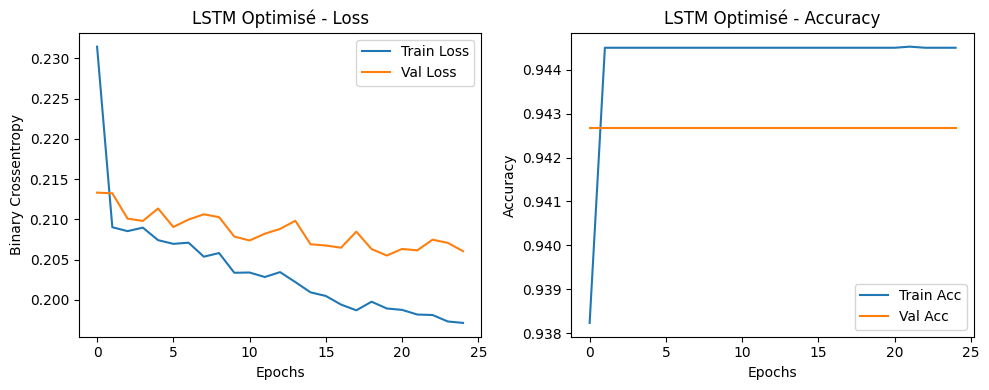

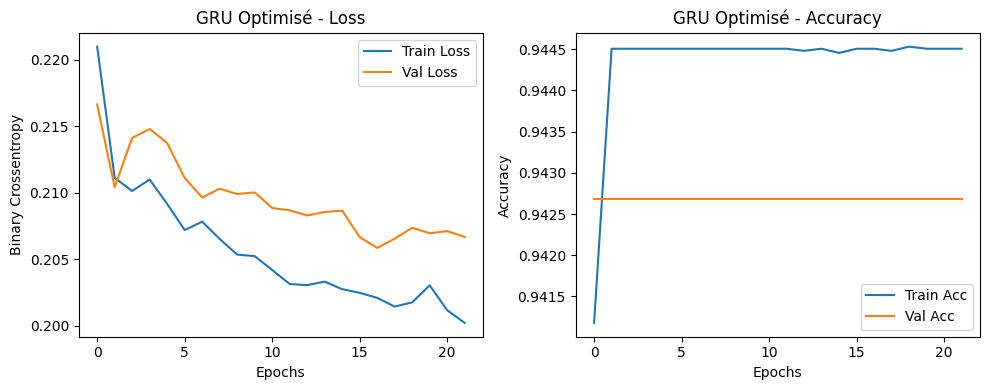

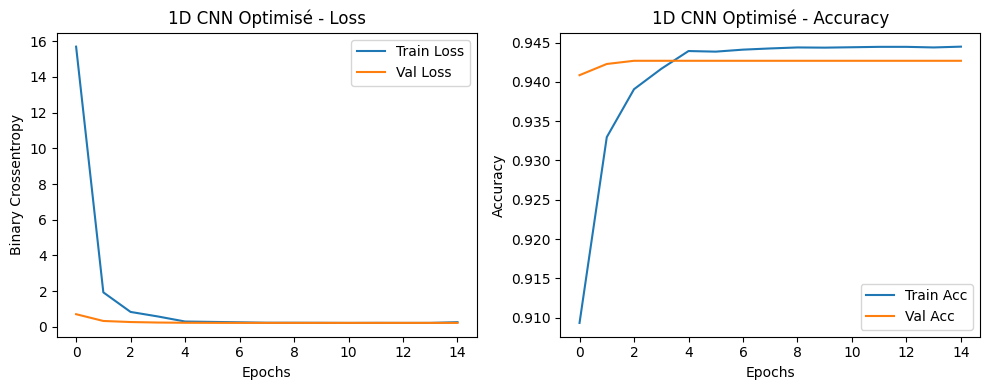

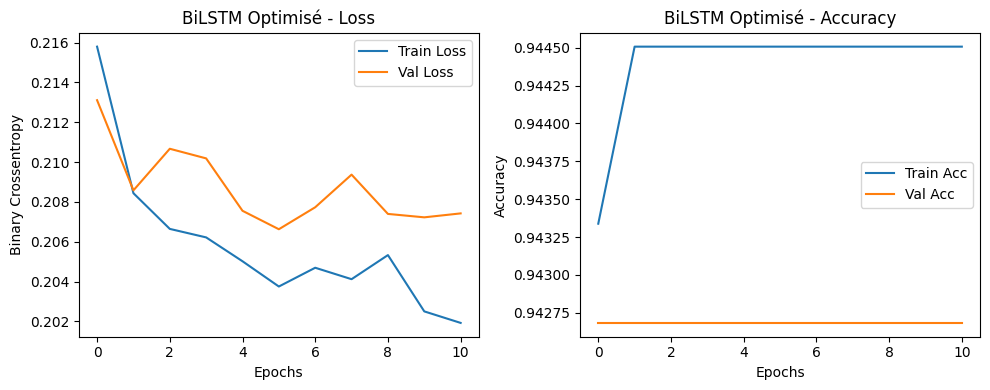

In [ ]:
plot_model_history(history_lstm, "LSTM Optimisé")
plot_model_history(history_gru, "GRU Optimisé")
plot_model_history(history_cnn, "1D CNN Optimisé")
plot_model_history(history_bilstm, "BiLSTM Optimisé")

**On équilibre notre dataset pour voir si cela va auglenter la performance des modèles**

In [ ]:
# puisque la classe 1 qui correspond aux entreprises qui font du faillite notre dataset n'est pas équilibré donc on doit générer de nouveux example pour la classe minoritaire
#car une dataset désiquilibré affecte la peerformance des modèles comme on a vue ci dessus

from sklearn.utils import resample


X_min = X_seq[y_seq == 1]
X_maj = X_seq[y_seq == 0]
y_min = y_seq[y_seq == 1]
y_maj = y_seq[y_seq == 0]

X_min_res, y_min_res = resample(X_min, y_min, replace=True, n_samples=len(y_maj), random_state=42)
X_bal = np.concatenate([X_maj, X_min_res])
y_bal = np.concatenate([y_maj, y_min_res])

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42)


# ***Benchmarking entre modèles après l'équilibrage du dataset***

**On va utiliser des modèles non optimisés au premier pas pour voir l'influence de l'équilibrage du dataset**

In [ ]:
# LSTM
lstm_model = Sequential([
    LSTM(32, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train, y_train, epochs=9, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stop])
evaluate_model(lstm_model, "LSTM")

# GRU
gru_model = Sequential([
    GRU(32, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dense(1, activation='sigmoid')
])
gru_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_gru = gru_model.fit(X_train, y_train, epochs=9, batch_size=64, validation_split=0.2, verbose=1)
evaluate_model(gru_model, "GRU")

# 1D CNN
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2])),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train, y_train, epochs=9, batch_size=64, validation_split=0.2, verbose=1)
evaluate_model(cnn_model, "1D CNN")

# BiLSTM
bilstm_model = Sequential([
    Bidirectional(LSTM(32), input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dense(1, activation='sigmoid')
])
bilstm_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=9, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stop])
evaluate_model(bilstm_model, "BiLSTM")


Epoch 1/9


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6014 - loss: 0.6644 - val_accuracy: 0.6401 - val_loss: 0.6361
Epoch 2/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6469 - loss: 0.6317 - val_accuracy: 0.6431 - val_loss: 0.6371
Epoch 3/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6491 - loss: 0.6310 - val_accuracy: 0.6588 - val_loss: 0.6209
Epoch 4/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6612 - loss: 0.6206 - val_accuracy: 0.6661 - val_loss: 0.6172
Epoch 5/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6722 - loss: 0.6126 - val_accuracy: 0.6668 - val_loss: 0.6125
Epoch 6/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6734 - loss: 0.6056 - val_accuracy: 0.6642 - val_loss: 0.6080
Epoch 7/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6728 - loss: 0.6050 - val_accuracy: 0.6649 - val_loss: 0.6125
Epoch 8/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6702 - loss: 0.6058 - val_accuracy: 0.67

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5855 - loss: 0.6726 - val_accuracy: 0.6392 - val_loss: 0.6356
Epoch 2/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6408 - loss: 0.6343 - val_accuracy: 0.6534 - val_loss: 0.6223
Epoch 3/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6579 - loss: 0.6210 - val_accuracy: 0.6627 - val_loss: 0.6142
Epoch 4/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6594 - loss: 0.6189 - val_accuracy: 0.6601 - val_loss: 0.6213
Epoch 5/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6610 - loss: 0.6199 - val_accuracy: 0.6693 - val_loss: 0.6091
Epoch 6/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6616 - loss: 0.6139 - val_accuracy: 0.6686 - val_loss: 0.6059
Epoch 7/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6641 - loss: 0.6117 - val_accuracy: 0.6740 - val_loss: 0.6078
Epoch 8/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6793 - loss: 0.5995 - val_accuracy: 0.67

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5573 - loss: 35.8050 - val_accuracy: 0.5950 - val_loss: 10.3981
Epoch 2/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5722 - loss: 13.0402 - val_accuracy: 0.5975 - val_loss: 5.5643
Epoch 3/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5757 - loss: 7.5970 - val_accuracy: 0.5082 - val_loss: 37.8920
Epoch 4/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5712 - loss: 8.9996 - val_accuracy: 0.5926 - val_loss: 3.4212
Epoch 5/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5808 - loss: 5.5395 - val_accuracy: 0.5878 - val_loss: 6.0079
Epoch 6/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5829 - loss: 4.3925 - val_accuracy: 0.5586 - val_loss: 5.3625
Epoch 7/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5767 - loss: 4.0153 - val_accuracy: 0.5510 - val_loss: 2.4825
Epoch 8/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5786 - loss: 2.9938 - val_accuracy: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6196 - loss: 0.6484 - val_accuracy: 0.6519 - val_loss: 0.6281
Epoch 2/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6508 - loss: 0.6251 - val_accuracy: 0.6554 - val_loss: 0.6174
Epoch 3/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6635 - loss: 0.6159 - val_accuracy: 0.6523 - val_loss: 0.6206
Epoch 4/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6613 - loss: 0.6175 - val_accuracy: 0.6633 - val_loss: 0.6133
Epoch 5/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6739 - loss: 0.6061 - val_accuracy: 0.6691 - val_loss: 0.6027
Epoch 6/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6769 - loss: 0.5973 - val_accuracy: 0.6876 - val_loss: 0.5903
Epoch 7/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6863 - loss: 0.5919 - val_accuracy: 0.6815 - val_loss: 0.5972
Epoch 8/9
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6897 - loss: 0.5863 - val_accuracy: 0.68

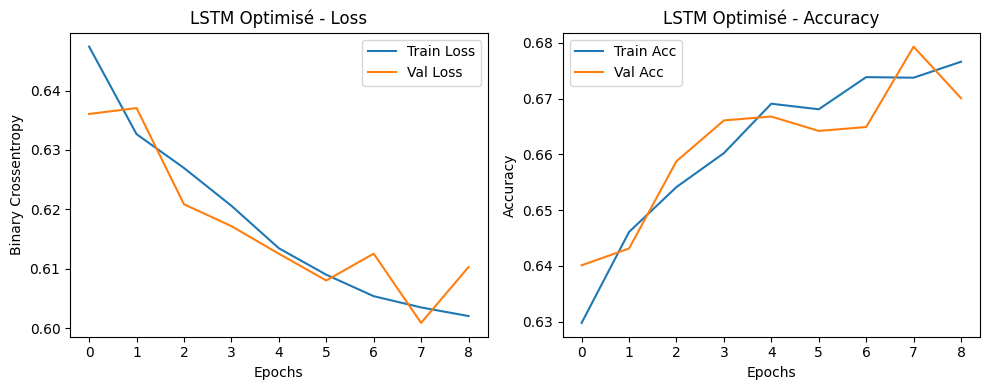

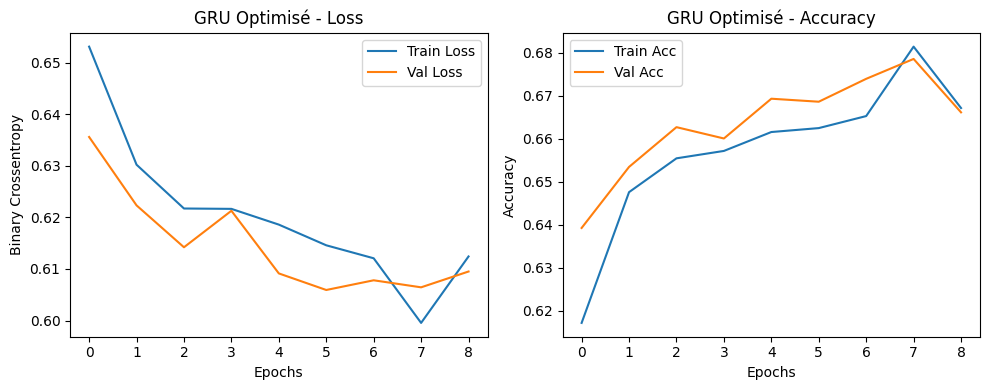

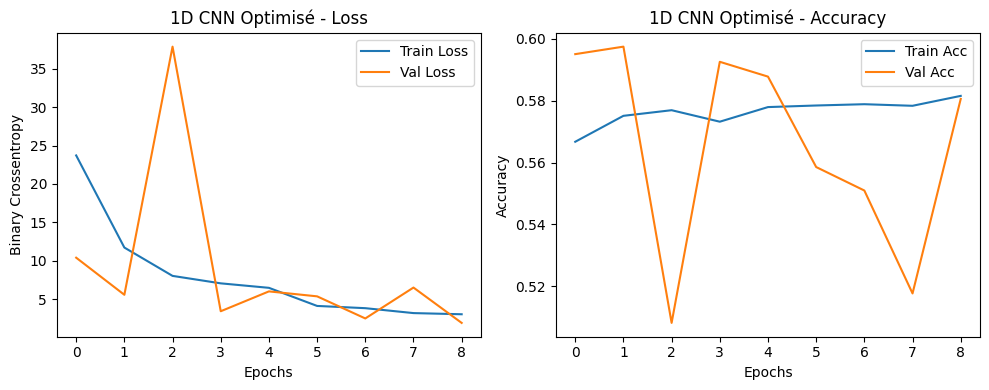

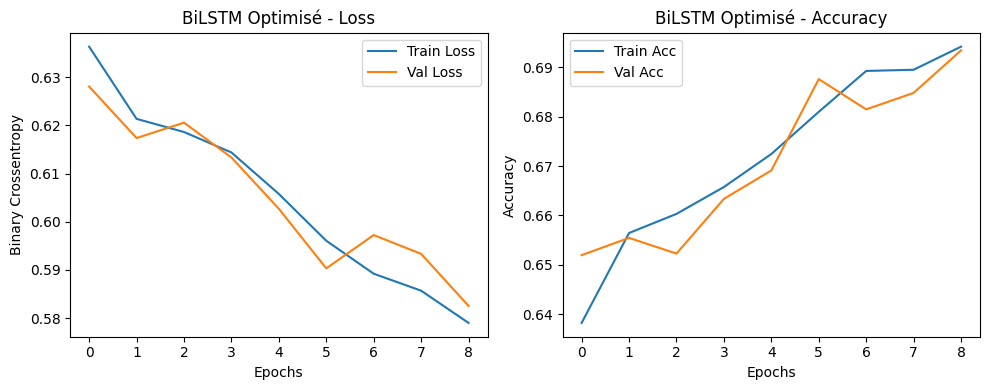

In [ ]:
plot_model_history(history_lstm, "LSTM Optimisé")
plot_model_history(history_gru, "GRU Optimisé")
plot_model_history(history_cnn, "1D CNN Optimisé")
plot_model_history(history_bilstm, "BiLSTM Optimisé")

**On va optimiser nos modèles par augmentation due nombre d'epochs pour voir si nos modèles peut apprendre plus et on va ajouter des technique comme early stopping pour éviter l'overfitting et on va ajouter d'autres couches et d'autres paramètres**

In [ ]:
# LSTM Optimisé
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
               callbacks=[early_stop, lr_reduce], verbose=1)
evaluate_model(lstm_model, "LSTM Optimisé")

# GRU Optimisé
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    GRU(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
gru_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_gru = gru_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
              callbacks=[early_stop, lr_reduce], verbose=1)
evaluate_model(gru_model, "GRU Optimisé")

# 1D CNN Optimisé
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
              callbacks=[early_stop, lr_reduce], verbose=1)
evaluate_model(cnn_model, "1D CNN Optimisé")

# BiLSTM Optimisé
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
bilstm_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
                 callbacks=[early_stop, lr_reduce], verbose=1)
evaluate_model(bilstm_model, "BiLSTM Optimisé")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6084 - loss: 0.6570 - val_accuracy: 0.6406 - val_loss: 0.6364 - learning_rate: 0.0010
Epoch 2/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6416 - loss: 0.6371 - val_accuracy: 0.6576 - val_loss: 0.6193 - learning_rate: 0.0010
Epoch 3/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6509 - loss: 0.6258 - val_accuracy: 0.6624 - val_loss: 0.6093 - learning_rate: 0.0010
Epoch 4/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6536 - loss: 0.6231 - val_accuracy: 0.6700 - val_loss: 0.6040 - learning_rate: 0.0010
Epoch 5/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6563 - loss: 0.6185 - val_accuracy: 0.6694 - val_loss: 0.6022 - learning_rate: 0.0010
Epoch 6/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6656 - loss: 0.6104 - val_accuracy: 0.6709 - val_loss: 0.5979 - learning_rate: 0.0010
Epoch 7/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6628 - loss: 0.612

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6002 - loss: 0.6621 - val_accuracy: 0.6528 - val_loss: 0.6276 - learning_rate: 0.0010
Epoch 2/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6405 - loss: 0.6352 - val_accuracy: 0.6562 - val_loss: 0.6229 - learning_rate: 0.0010
Epoch 3/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6457 - loss: 0.6311 - val_accuracy: 0.6648 - val_loss: 0.6137 - learning_rate: 0.0010
Epoch 4/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6508 - loss: 0.6271 - val_accuracy: 0.6691 - val_loss: 0.6080 - learning_rate: 0.0010
Epoch 5/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6589 - loss: 0.6171 - val_accuracy: 0.6706 - val_loss: 0.6025 - learning_rate: 0.0010
Epoch 6/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6624 - loss: 0.6179 - val_accuracy: 0.6800 - val_loss: 0.5938 - learning_rate: 0.0010
Epoch 7/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6657 - loss: 0.61

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5291 - loss: 76.4381 - val_accuracy: 0.5134 - val_loss: 0.7182 - learning_rate: 0.0010
Epoch 2/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5166 - loss: 1.2507 - val_accuracy: 0.5033 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 3/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5120 - loss: 0.8620 - val_accuracy: 0.5029 - val_loss: 0.6916 - learning_rate: 0.0010
Epoch 4/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5072 - loss: 0.7737 - val_accuracy: 0.5030 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 5/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4968 - loss: 0.7194 - val_accuracy: 0.5030 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 6/50
1148/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4991 - loss: 0.7052
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4991 - loss: 0.7052

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.6236 - loss: 0.6462 - val_accuracy: 0.6491 - val_loss: 0.6222 - learning_rate: 0.0010
Epoch 2/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6467 - loss: 0.6289 - val_accuracy: 0.6720 - val_loss: 0.6009 - learning_rate: 0.0010
Epoch 3/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.6680 - loss: 0.6097 - val_accuracy: 0.6857 - val_loss: 0.5881 - learning_rate: 0.0010
Epoch 4/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.6673 - loss: 0.6064 - val_accuracy: 0.6885 - val_loss: 0.5814 - learning_rate: 0.0010
Epoch 5/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.6739 - loss: 0.6007 - val_accuracy: 0.6911 - val_loss: 0.5793 - learning_rate: 0.0010
Epoch 6/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.6795 - loss: 0.5951 - val_accuracy: 0.6932 - val_loss: 0.5741 - learning_rate: 0.0010
Epoch 7/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6820 

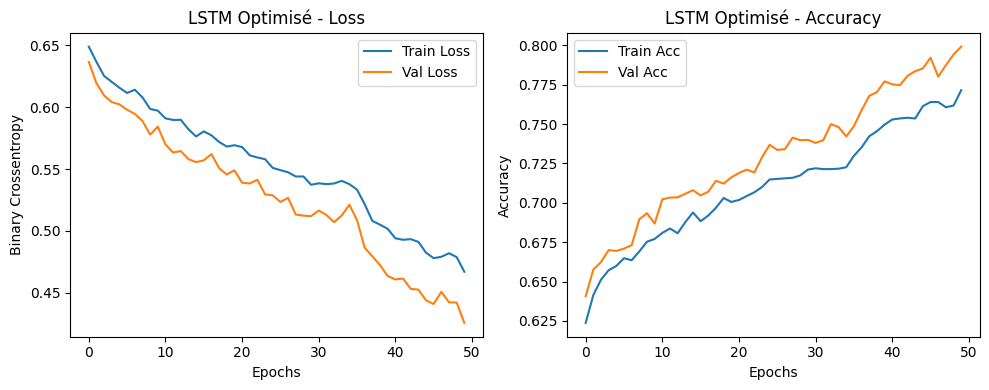

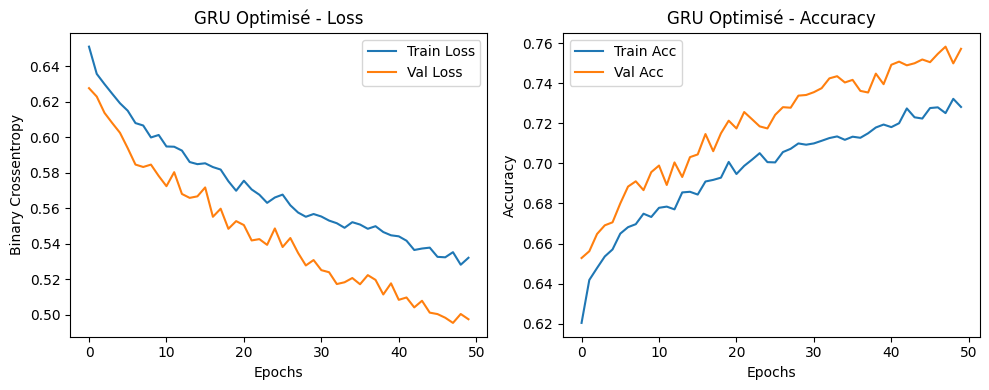

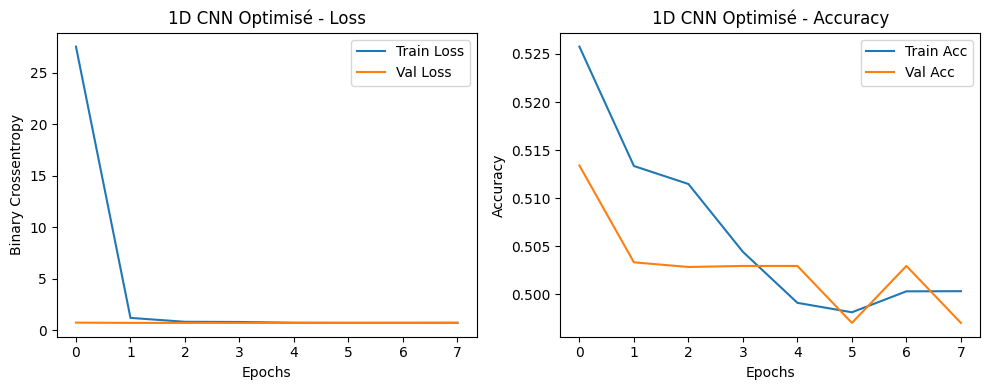

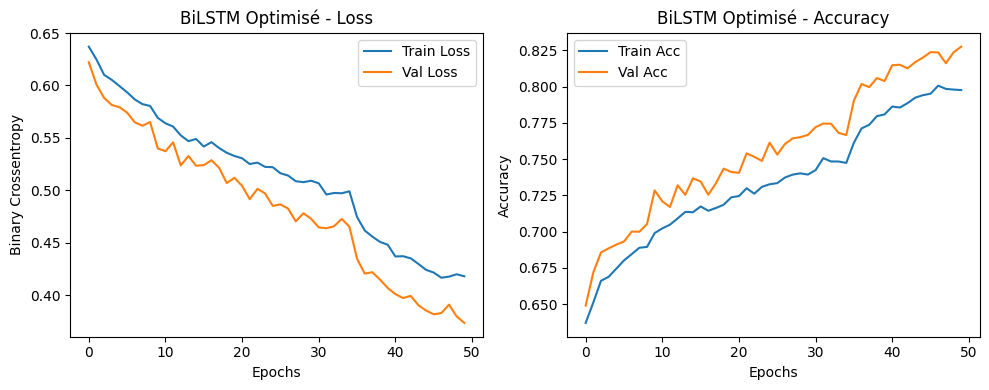

In [ ]:
plot_model_history(history_lstm, "LSTM Optimisé")
plot_model_history(history_gru, "GRU Optimisé")
plot_model_history(history_cnn, "1D CNN Optimisé")
plot_model_history(history_bilstm, "BiLSTM Optimisé")

In [ ]:
# modèles après sampling et pour les séquences de 5 années
lstm_model.save("modelsSeq2/lstm_model.keras")
gru_model.save("modelsSeq2/gru_model.keras")
cnn_model.save("modelsSeq2/cnn_model.keras")
bilstm_model.save("modelsSeq2/bilstm_model.keras")

# **On va voir maintenant si la longueur des séquences a un effet sur les modèles parce que pour les modèles de forecasting et deep learnign en général tant qu'on a beaucoup de données tant que le modèle peut apprendre les séquences d'une manière claire**

In [ ]:
SEQ_LEN = 5


sequences = []
labels = []

#cela filtre les entreprises qui ont des rows moins de 5
for company, group in company_groups:
    group = group.sort_values('year')
    features = group[feature_cols].values
    targets = group['bankrupt_next_year'].values
    if len(group) < SEQ_LEN + 1:
        continue
    for i in range(len(group) - SEQ_LEN):
        seq = features[i:i + SEQ_LEN]
        label = targets[i + SEQ_LEN]
        sequences.append(seq)
        labels.append(label)
X_seq = np.array(sequences)
y_seq = np.array(labels)

# Oversample minority class (bankrupt = 1)
X_min = X_seq[y_seq == 1]
X_maj = X_seq[y_seq == 0]
y_min = y_seq[y_seq == 1]
y_maj = y_seq[y_seq == 0]

X_min_res, y_min_res = resample(X_min, y_min, replace=True, n_samples=len(y_maj), random_state=42)
X_balanced = np.concatenate([X_maj, X_min_res])
y_balanced = np.concatenate([y_maj, y_min_res])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)


In [ ]:
# LSTM
lstm_model = Sequential([
    LSTM(32, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train, y_train, epochs=9, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stop])
evaluate_model(lstm_model, "LSTM")

# GRU
gru_model = Sequential([
    GRU(32, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dense(1, activation='sigmoid')
])
gru_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_gru = gru_model.fit(X_train, y_train, epochs=9, batch_size=64, validation_split=0.2, verbose=1)
evaluate_model(gru_model, "GRU")

# 1D CNN
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2])),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train, y_train, epochs=9, batch_size=64, validation_split=0.2, verbose=1)
evaluate_model(cnn_model, "1D CNN")

# BiLSTM
bilstm_model = Sequential([
    Bidirectional(LSTM(32), input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dense(1, activation='sigmoid')
])
bilstm_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=9, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stop])
evaluate_model(bilstm_model, "BiLSTM")


Epoch 1/9


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


797/797 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5973 - loss: 0.6633 - val_accuracy: 0.6679 - val_loss: 0.6218
Epoch 2/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6596 - loss: 0.6183 - val_accuracy: 0.6779 - val_loss: 0.5985
Epoch 3/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6768 - loss: 0.5991 - val_accuracy: 0.7039 - val_loss: 0.5826
Epoch 4/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6969 - loss: 0.5842 - val_accuracy: 0.6924 - val_loss: 0.5851
Epoch 5/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6999 - loss: 0.5733 - val_accuracy: 0.6986 - val_loss: 0.5777
Epoch 6/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6938 - loss: 0.5806 - val_accuracy: 0.7049 - val_loss: 0.5688
Epoch 7/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7049 - loss: 0.5648 - val_accuracy: 0.7132 - val_loss: 0.5572
Epoch 8/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7089 - loss: 0.5563 - val_accuracy: 0.7170 - val_loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


797/797 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5800 - loss: 0.6997 - val_accuracy: 0.6633 - val_loss: 0.6163
Epoch 2/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6655 - loss: 0.6126 - val_accuracy: 0.6848 - val_loss: 0.5969
Epoch 3/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6811 - loss: 0.5963 - val_accuracy: 0.6852 - val_loss: 0.6017
Epoch 4/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6831 - loss: 0.5960 - val_accuracy: 0.7071 - val_loss: 0.5792
Epoch 5/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6854 - loss: 0.5886 - val_accuracy: 0.6892 - val_loss: 0.5814
Epoch 6/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6906 - loss: 0.5786 - val_accuracy: 0.6995 - val_loss: 0.5721
Epoch 7/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6949 - loss: 0.5739 - val_accuracy: 0.6879 - val_loss: 0.5814
Epoch 8/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6913 - loss: 0.5737 - val_accuracy: 0.7082 - val_loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5844 - loss: 40.6072 - val_accuracy: 0.6077 - val_loss: 10.3220
Epoch 2/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5992 - loss: 12.3567 - val_accuracy: 0.6050 - val_loss: 11.6100
Epoch 3/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6105 - loss: 10.0685 - val_accuracy: 0.5976 - val_loss: 10.7875
Epoch 4/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5998 - loss: 9.0830 - val_accuracy: 0.6364 - val_loss: 6.4405
Epoch 5/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6115 - loss: 6.9571 - val_accuracy: 0.6578 - val_loss: 4.4294
Epoch 6/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6189 - loss: 5.4067 - val_accuracy: 0.5609 - val_loss: 5.9576
Epoch 7/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6212 - loss: 5.2303 - val_accuracy: 0.6501 - val_loss: 4.3991
Epoch 8/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6156 - loss: 5.7080 - val_accuracy: 0.6079 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


797/797 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6202 - loss: 0.6476 - val_accuracy: 0.6807 - val_loss: 0.5977
Epoch 2/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6795 - loss: 0.5928 - val_accuracy: 0.7045 - val_loss: 0.5665
Epoch 3/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7018 - loss: 0.5691 - val_accuracy: 0.7122 - val_loss: 0.5592
Epoch 4/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7083 - loss: 0.5559 - val_accuracy: 0.7066 - val_loss: 0.5645
Epoch 5/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7187 - loss: 0.5517 - val_accuracy: 0.7235 - val_loss: 0.5368
Epoch 6/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7285 - loss: 0.5292 - val_accuracy: 0.7355 - val_loss: 0.5222
Epoch 7/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7363 - loss: 0.5251 - val_accuracy: 0.7388 - val_loss: 0.5194
Epoch 8/9
797/797 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7432 - loss: 0.5128 - val_accuracy: 0.7553 - val_loss

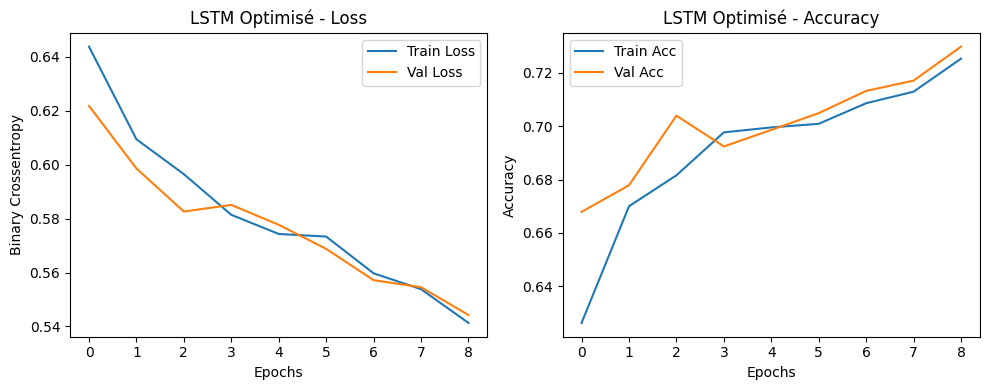

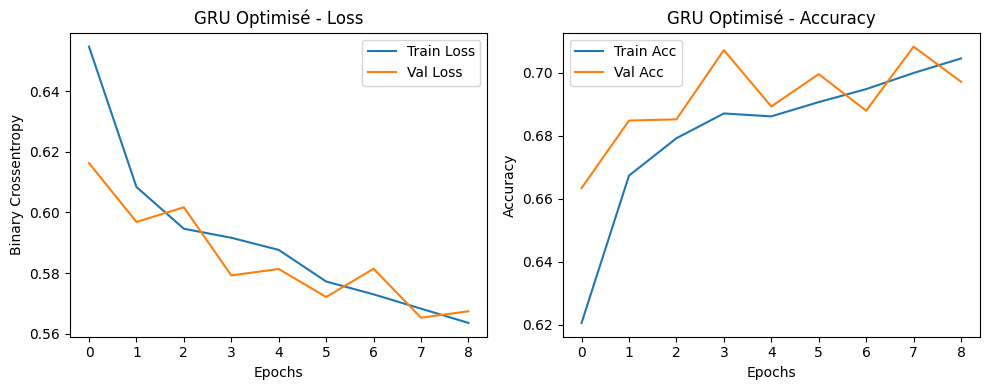

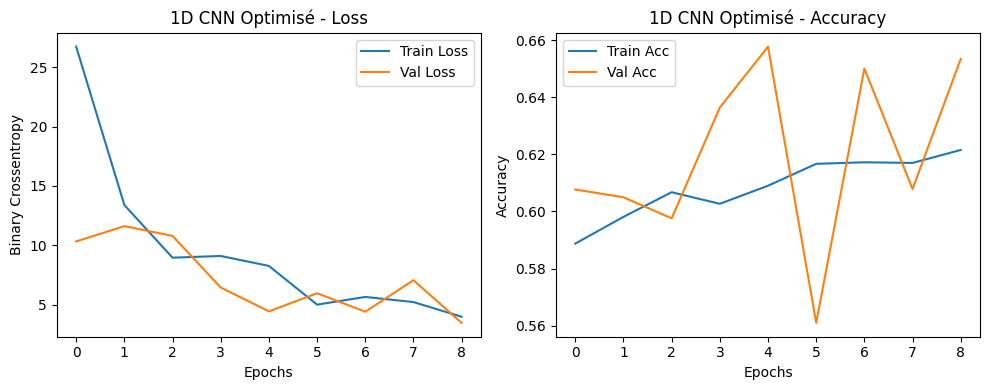

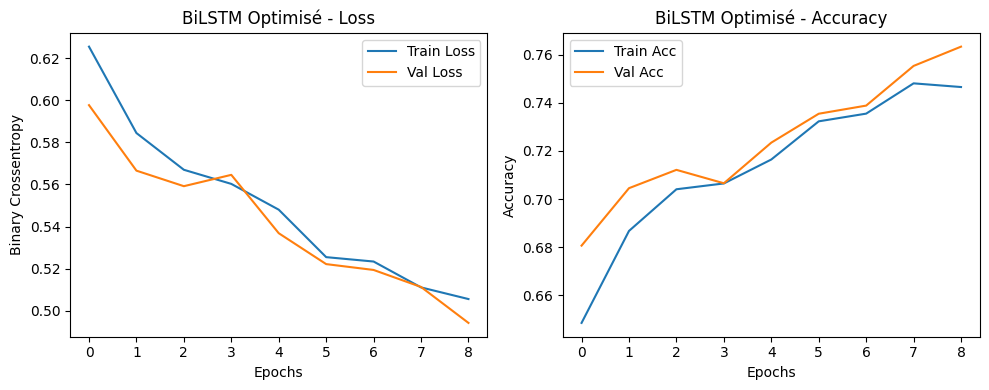

In [ ]:
plot_model_history(history_lstm, "LSTM Optimisé")
plot_model_history(history_gru, "GRU Optimisé")
plot_model_history(history_cnn, "1D CNN Optimisé")
plot_model_history(history_bilstm, "BiLSTM Optimisé")

**Optimisation**

In [ ]:
# LSTM Optimisé
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
               callbacks=[early_stop, lr_reduce], verbose=1)
evaluate_model(lstm_model, "LSTM Optimisé")

# GRU Optimisé
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    GRU(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
gru_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
gru_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
              callbacks=[early_stop, lr_reduce], verbose=1)
evaluate_model(gru_model, "GRU Optimisé")

# 1D CNN Optimisé
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
              callbacks=[early_stop, lr_reduce], verbose=1)
evaluate_model(cnn_model, "1D CNN Optimisé")

# BiLSTM Optimisé
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
bilstm_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
bilstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
                 callbacks=[early_stop, lr_reduce], verbose=1)
evaluate_model(bilstm_model, "BiLSTM Optimisé")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


797/797 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6236 - loss: 0.6393 - val_accuracy: 0.6870 - val_loss: 0.5830 - learning_rate: 0.0010
Epoch 2/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6914 - loss: 0.5841 - val_accuracy: 0.7152 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 3/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7064 - loss: 0.5617 - val_accuracy: 0.7243 - val_loss: 0.5391 - learning_rate: 0.0010
Epoch 4/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7109 - loss: 0.5514 - val_accuracy: 0.7215 - val_loss: 0.5368 - learning_rate: 0.0010
Epoch 5/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7234 - loss: 0.5428 - val_accuracy: 0.7511 - val_loss: 0.5036 - learning_rate: 0.0010
Epoch 6/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7324 - loss: 0.5238 - val_accuracy: 0.7548 - val_loss: 0.4926 - learning_rate: 0.0010
Epoch 7/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.7444 - loss: 0.5091 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


797/797 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6211 - loss: 0.6490 - val_accuracy: 0.6747 - val_loss: 0.6015 - learning_rate: 0.0010
Epoch 2/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6729 - loss: 0.6003 - val_accuracy: 0.7019 - val_loss: 0.5749 - learning_rate: 0.0010
Epoch 3/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6926 - loss: 0.5825 - val_accuracy: 0.7234 - val_loss: 0.5443 - learning_rate: 0.0010
Epoch 4/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6982 - loss: 0.5724 - val_accuracy: 0.7270 - val_loss: 0.5373 - learning_rate: 0.0010
Epoch 5/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7185 - loss: 0.5429 - val_accuracy: 0.7322 - val_loss: 0.5223 - learning_rate: 0.0010
Epoch 6/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7204 - loss: 0.5347 - val_accuracy: 0.7147 - val_loss: 0.5245 - learning_rate: 0.0010
Epoch 7/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7191 - loss: 0.5313 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5310 - loss: 92.4614 - val_accuracy: 0.5259 - val_loss: 0.7018 - learning_rate: 0.0010
Epoch 2/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5059 - loss: 0.8906 - val_accuracy: 0.5024 - val_loss: 0.7020 - learning_rate: 0.0010
Epoch 3/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4947 - loss: 0.7834 - val_accuracy: 0.4867 - val_loss: 0.6947 - learning_rate: 0.0010
Epoch 4/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4916 - loss: 0.7458 - val_accuracy: 0.4986 - val_loss: 0.6961 - learning_rate: 0.0010
Epoch 5/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4942 - loss: 0.7281 - val_accuracy: 0.4939 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 6/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4930 - loss: 0.7030 - val_accuracy: 0.4984 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 7/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4977 - loss: 0.7146 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


797/797 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.6445 - loss: 0.6248 - val_accuracy: 0.7232 - val_loss: 0.5381 - learning_rate: 0.0010
Epoch 2/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.7133 - loss: 0.5522 - val_accuracy: 0.7490 - val_loss: 0.5069 - learning_rate: 0.0010
Epoch 3/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.7381 - loss: 0.5178 - val_accuracy: 0.7647 - val_loss: 0.4798 - learning_rate: 0.0010
Epoch 4/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.7443 - loss: 0.5004 - val_accuracy: 0.7834 - val_loss: 0.4455 - learning_rate: 0.0010
Epoch 5/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.7572 - loss: 0.4821 - val_accuracy: 0.7811 - val_loss: 0.4488 - learning_rate: 0.0010
Epoch 6/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.7657 - loss: 0.4697 - val_accuracy: 0.7965 - val_loss: 0.4188 - learning_rate: 0.0010
Epoch 7/50
797/797 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.7666 - loss: 0.4677

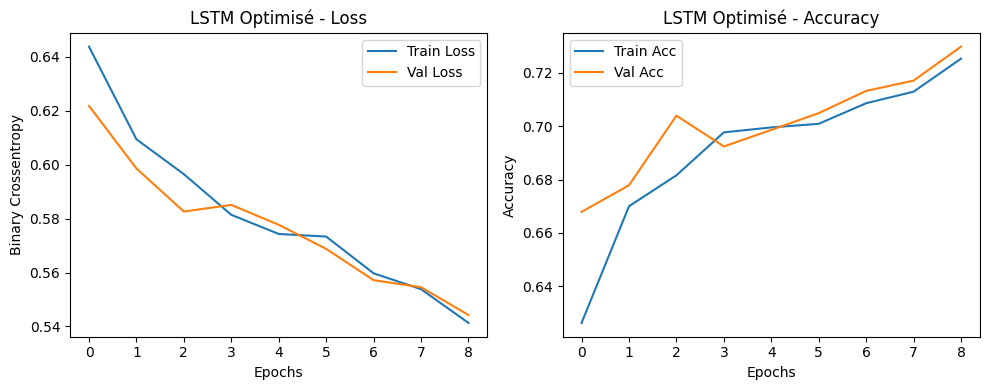

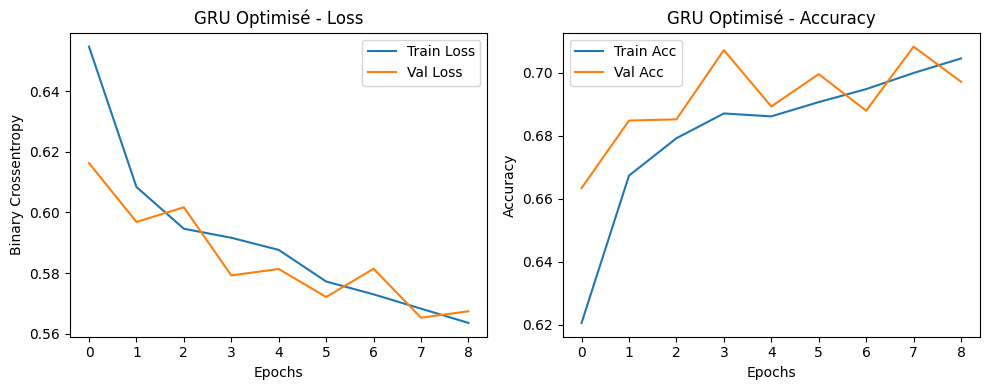

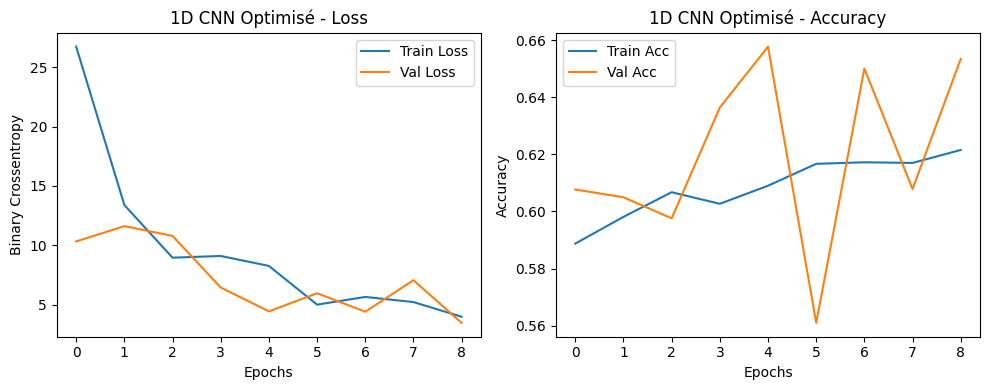

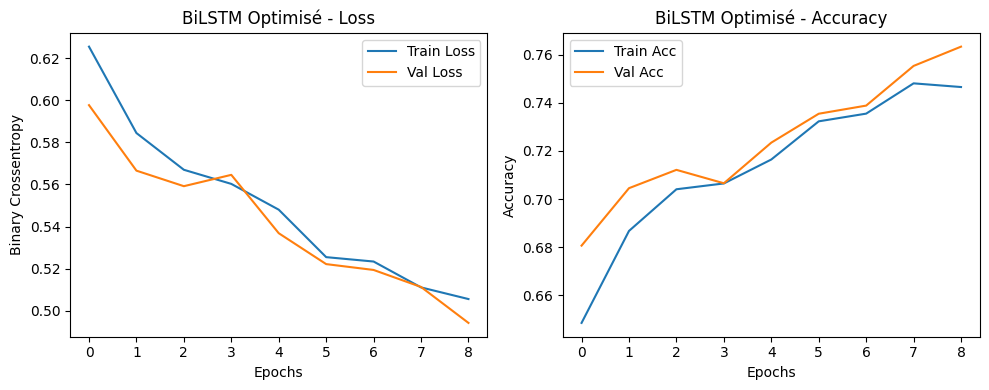

In [ ]:
plot_model_history(history_lstm, "LSTM Optimisé")
plot_model_history(history_gru, "GRU Optimisé")
plot_model_history(history_cnn, "1D CNN Optimisé")
plot_model_history(history_bilstm, "BiLSTM Optimisé")

In [ ]:
import os

os.makedirs("modelsSeq5", exist_ok=True)

# modèles après sampling et pour les séquences de 5 années
lstm_model.save("modelsSeq5/lstm_model.keras")
gru_model.save("modelsSeq5/gru_model.keras")
cnn_model.save("modelsSeq5/cnn_model.keras")
bilstm_model.save("modelsSeq5/bilstm_model.keras")


# **On va optimiser maintenant le modèle BiLSTM  puisque c'est celui qui a été choisi à cause de son accuracy et l'équilibre entre precision f1_score et recall c'est le modèle qui est le plus équilibré et il a les valuers maximal**

**On augmente encore le nombre d'epochs et on ajoute d'autres couches pour voir si le modèle peut apprendre encore sans overfitting**

In [ ]:
from sklearn.utils import class_weight


cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/70
797/797 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.6333 - loss: 0.6311 - val_accuracy: 0.6919 - val_loss: 0.5813 - learning_rate: 0.0010
Epoch 2/70
797/797 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6968 - loss: 0.5737 - val_accuracy: 0.7417 - val_loss: 0.5243 - learning_rate: 0.0010
Epoch 3/70
797/797 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.7174 - loss: 0.5489 - val_accuracy: 0.7467 - val_loss: 0.5017 - learning_rate: 0.0010
Epoch 4/70
797/797 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.7308 - loss: 0.5278 - val_accuracy: 0.7640 - val_loss: 0.4792 - learning_rate: 0.0010
Epoch 5/70
797/797 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7394 - loss: 0.5178 - val_accuracy: 0.7774 - val_loss: 0.4659 - learning_rate: 0.0010
Epoch 6/70
797/797 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.7453 - loss: 0.4985 - val_accuracy: 0.7776 - val_loss: 0.4533 - learning_rate: 0.0010
Epoch 7/70
797/797 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.7562 - l

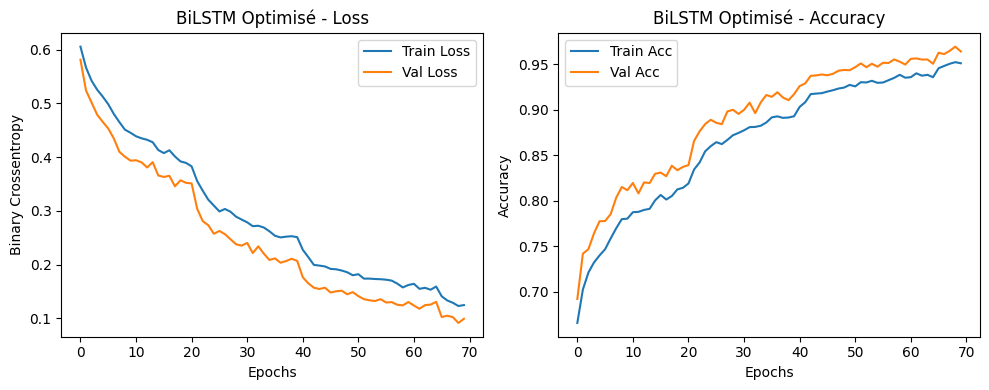

In [ ]:
# i should have used checkpoints instead of running a new model but from mistakes we learn for the next time inchaellah
bilstm_model_70_epochs = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
bilstm_model_70_epochs.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

# Training
history_bilstm_70_epochs = bilstm_model_70_epochs.fit(
    X_train, y_train,
    epochs=70,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)

plot_model_history(history_bilstm_70_epochs, "BiLSTM Optimisé")

In [ ]:
evaluate_model(bilstm_model_70_epochs, "BiLSTM Optimisé")

498/498 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
\n--- BiLSTM Optimisé ---
Classification Report:\n               precision    recall  f1-score   support

           0       0.99      0.95      0.97      7965
           1       0.95      0.99      0.97      7964

    accuracy                           0.97     15929
   macro avg       0.97      0.97      0.97     15929
weighted avg       0.97      0.97      0.97     15929

Confusion Matrix:\n [[7578  387]
 [  72 7892]]
ROC AUC Score: 0.9937703185994223


In [ ]:
bilstm_model_70_epochs.save("bilstm_optimized_70_epochs.keras")


In [ ]:
bilstm_model_70_epochs.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_15                │ (None, 5, 128)         │        42,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,825 (335.25 KB)

 Trainable params: 85,825 (335.25 KB)

 Non-trainable params: 0 (0.00 B)

# **Intégration de machine learning pour des explications**

In [ ]:
import shap
from tensorflow.keras.models import  Model,load_model
from xgboost import XGBClassifier



bilstm_model_70_epochs = load_model("bilstm_optimized_70_epochs.keras")
_ = bilstm_model_70_epochs.predict(X_train[:1])  # This is required!
layer_names = [layer.name for layer in bilstm_model_70_epochs.layers]
layer_names


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


['bidirectional_15',
 'dropout_45',
 'bidirectional_16',
 'dropout_46',
 'dense_41',
 'dropout_47',
 'dense_42']

In [ ]:
inputs=bilstm_model_70_epochs.inputs

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_33']
Received: inputs=Tensor(shape=(32, 5, 18))
  warnings.warn(msg)


1985/1992 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_33']
Received: inputs=Tensor(shape=(None, 5, 18))
  warnings.warn(msg)


1992/1992 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:09:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost on BiLSTM Embeddings ---
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      7965
           1       0.97      1.00      0.98      7964

    accuracy                           0.98     15929
   macro avg       0.98      0.98      0.98     15929
weighted avg       0.98      0.98      0.98     15929

Confusion Matrix:
 [[7702  263]
 [   9 7955]]
ROC AUC Score: 0.9950471960608678


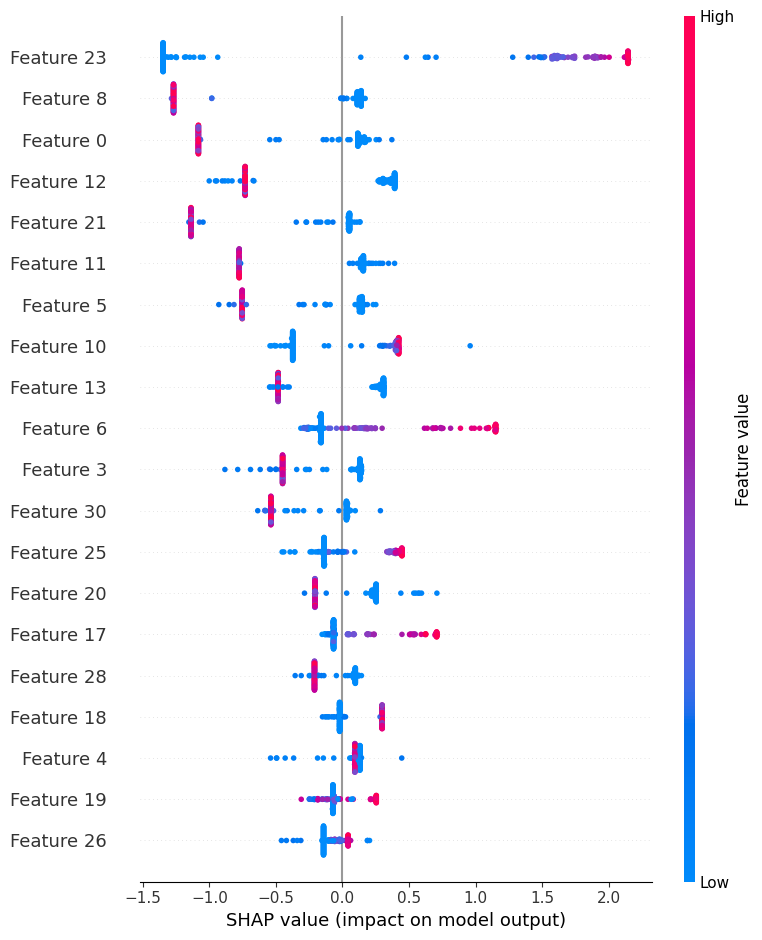

In [ ]:

# Extract last hidden representation for XGBoost
embedding_model = Model(
    inputs,
    outputs=bilstm_model_70_epochs.get_layer("dense_41").output
)
X_train_embed = embedding_model.predict(X_train)
X_test_embed = embedding_model.predict(X_test)

# XGBoost Training
xgb_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_embed, y_train)

# Evaluation XGBoost
y_xgb = xgb_model.predict(X_test_embed)
print("\n--- XGBoost on BiLSTM Embeddings ---")
print("Classification Report:\n", classification_report(y_test, y_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, xgb_model.predict_proba(X_test_embed)[:, 1]))

# SHAP explainability
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_embed[:200])  # Limit for speed

shap.summary_plot(shap_values, X_test_embed[:200])

In [ ]:
import joblib
joblib.dump(xgb_model, "xgb_for_explaining_bilstm_results.pkl")

['xgb_for_explaining_bilstm_results.pkl']